# **1. Import Libraries**

In [1]:
# Reloading modules automatically when they change
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

import plotly.graph_objects as go

from forecaster.data import fingrid, spot
from forecaster.models import models, train

# **2. Load Data**

In [4]:
# Load the data
file_path = '../data/spot_prices_fi_2016_2023.csv'

# Define dict where predictions and metrices are stored
predictions = {} # Store the predictions for the test set
predictions_train = {} # Store the predictions for the training set
metrices = {} # Store the metrices for the test set
metrices_train = {} # Store the metrices for the training set
horizon = 24

# Load the spot data
spot_data = spot.load_spot_data(file_path, date_col="date", price_col="elspot-fi")
spot_data.head()

y
date                            
2016-01-01 00:00:00+02:00  15.91
2016-01-01 01:00:00+02:00  16.39
2016-01-01 02:00:00+02:00  16.04
2016-01-01 03:00:00+02:00  15.74
2016-01-01 04:00:00+02:00  15.57

In [6]:
# plot the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=spot_data.index, y=spot_data.y, mode='lines', name='Spot Price'))
# add zoom
fig.update_layout(xaxis_rangeslider_visible=True)
fig.update_layout(title='Spot Price Over Time', xaxis_title='Time', yaxis_title='Spot Price')
fig.show()

In [7]:
# Create a copy of the data that we can add columns to without modifying the original data
df = spot_data.copy()

# **3. Model Training**

#### **3.1. Simple Baseline Models**

In [ ]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression

from forecaster.utils import create_daily_lag_features, extract_time_features


class ForecastingModel:

    def __init__(self, 
                 daily_price_lags: list, 
                 time_features: bool=False,
                 efternal_features: list=[],
                 daily_external_lags: list=[],
                 fit_coeffs: bool=True,
                 ):
        """
        Initializes the ForecastingModel with the specified lags for daily prices and external features.
        """
        self.daily_price_lags = daily_price_lags
        self.time_features = time_features
        self.external_features = efternal_features
        self.daily_external_lags = daily_external_lags
        self.nFeatures = len(daily_price_lags) + time_features*48 + len(efternal_features) * len(daily_external_lags)
        self.coeffs = np.full(self.nFeatures, np.nan)
        self.fit_coeffs = fit_coeffs
        self.model = LinearRegression(fit_intercept=False)

    def preprocess_data(self, df):
        
        df_with_features = df.copy()

        if self.daily_price_lags:
            df_with_features = create_daily_lag_features(df_with_features, 'y', self.daily_price_lags, average=True)

        if self.time_features:
            df_with_features = extract_time_features(df_with_features)

        df_with_features.dropna(how="any", inplace=True)

        return df_with_features

    def fit(self, X, y):
        # Fit coefficients useing least squares
        if self.fit_coeffs:
            a = 1
        # Else just coeffs that sum to unity, only makes sense for models that only used lagged price feautures
        else:   
            self.coeffs = np.ones(self.nFeatures) / self.nFeatures

    def predict(self, X):
        y_hat = np.dot(X, self.coeffs)
        return pd.Series(y_hat, index=X.index)
    

In [52]:
X_train = df_with_features.drop(columns='y')
y_train = df_with_features['y']
baseline_model.fit(X_train, y_train)

In [53]:
prediction = baseline_model.predict(X_train)
prediction.head()

date
2016-01-02 00:00:00+02:00    16.907083
2016-01-02 01:00:00+02:00    16.907083
2016-01-02 02:00:00+02:00    16.907083
2016-01-02 03:00:00+02:00    16.907083
2016-01-02 04:00:00+02:00    16.907083
dtype: float64

In [ ]:
baseline_model = ForecastingModel(daily_price_lags=[1])
df_with_features = baseline_model.preprocess_data(df)

train.year_on_year_training(df_with_features, baseline_model)
df_with_features.head(40)


y  y_lag_avg_1
date                                         
2016-01-02 00:00:00+02:00  16.25    16.907083
2016-01-02 01:00:00+02:00  16.47    16.907083
2016-01-02 02:00:00+02:00  15.89    16.907083
2016-01-02 03:00:00+02:00  15.03    16.907083
2016-01-02 04:00:00+02:00  13.19    16.907083
2016-01-02 05:00:00+02:00  12.69    16.907083
2016-01-02 06:00:00+02:00  12.94    16.907083
2016-01-02 07:00:00+02:00  13.59    16.907083
2016-01-02 08:00:00+02:00  17.37    16.907083
2016-01-02 09:00:00+02:00  19.34    16.907083
2016-01-02 10:00:00+02:00  19.96    16.907083
2016-01-02 11:00:00+02:00  19.91    16.907083
2016-01-02 12:00:00+02:00  16.14    16.907083
2016-01-02 13:00:00+02:00  15.87    16.907083
2016-01-02 14:00:00+02:00  19.97    16.907083
2016-01-02 15:00:00+02:00  27.76    16.907083
2016-01-02 16:00:00+02:00  39.89    16.907083
2016-01-02 17:00:00+02:00  39.89    16.907083
2016-01-02 18:00:00+02:00  39.87    16.907083
2016-01-02 19:00:00+02:00  39.89    16.907083
2016-01-02 20:00:00+02:00  34.78    16.907083
2016-01-02 21:00:00+02:00  30.08    16.907083
2016-01-02 22:00:00+02:00  31.36    16.907083
2016-01-02 23:00:00+02:00  27.13    16.907083
2016-01-03 00:00:00+02:00  23.61    23.135833
2016-01-03 01:00:00+02:00  17.95    23.135833
2016-01-03 02:00:00+02:00  15.87    23.135833
2016-01-03 03:00:00+02:00  15.76    23.135833
2016-01-03 04:00:00+02:00  15.59    23.135833
2016-01-03 05:00:00+02:00  15.69    23.135833
2016-01-03 06:00:00+02:00  15.83    23.135833
2016-01-03 07:00:00+02:00  14.98    23.135833
2016-01-03 08:00:00+02:00  15.53    23.135833
2016-01-03 09:00:00+02:00  15.79    23.135833
2016-01-03 10:00:00+02:00  16.36    23.135833
2016-01-03 11:00:00+02:00  17.15    23.135833
2016-01-03 12:00:00+02:00  17.94    23.135833
2016-01-03 13:00:00+02:00  17.94    23.135833
2016-01-03 14:00:00+02:00  17.66    23.135833
2016-01-03 15:00:00+02:00  23.40    23.135833

In [ ]:
wa_model = models.WindowAverageModel()



# year on year training
result_wa, wa_metrics = train.year_on_year_training(df, wa_model, refit=True)
predictions['Windowed average'] = [{'predictions': result_wa}]
metrices['Windowed average'] = wa_metrics
print(wa_metrics)

Training model for year 2016


NameError: name 'ts_prediction' is not defined

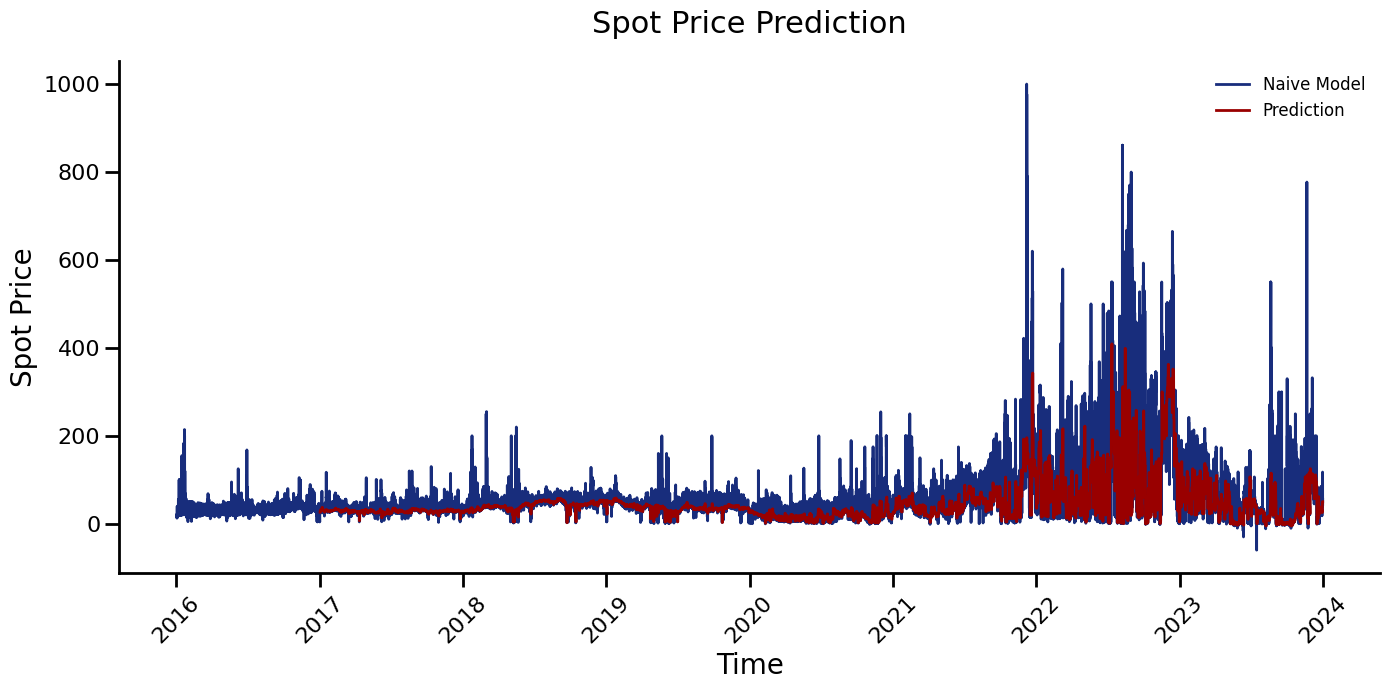

In [ ]:
# Plot the predictions
plot_spot_price_predictions(df['y'], result_na, 'Naive Model')

In [ ]:
# plot the data
fig = go.Figure()
fig.add_trace(go.Scatter(x=spot_data.index, y=spot_data.y, mode='lines', name='Spot Price'))
fig.add_trace(go.Scatter(x=spot_data.index, y=spot_data.y, mode='lines', name='Spot Price'))
# add zoom
fig.update_layout(xaxis_rangeslider_visible=True)
fig.update_layout(title='Spot Price Over Time', xaxis_title='Time', yaxis_title='Spot Price')
fig.show()

In [13]:
ha = HistoricalAverageModel()

# year on year training
result_ha, ha_metrics = year_on_year_training(df, ha, refit=True)
predictions['Historical Average'] = [{'predictions': result_ha}]
metrices['Historical Average'] = ha_metrics
print(ha_metrics)

Training model for year 2016
Initial training completed with training size: 8784 Indexes: 2016-01-01 00:00:00+02:00 - 2016-12-31 23:00:00+02:00
Testing window 0: Indexes 2017-01-01 00:00:00+02:00 - 2017-01-01 23:00:00+02:00
Retrained model with updated training size: 8808 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-01 23:00:00+02:00
Testing window 1: Indexes 2017-01-02 00:00:00+02:00 - 2017-01-02 23:00:00+02:00
Retrained model with updated training size: 8832 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-02 23:00:00+02:00
Testing window 2: Indexes 2017-01-03 00:00:00+02:00 - 2017-01-03 23:00:00+02:00
Retrained model with updated training size: 8856 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-03 23:00:00+02:00
Testing window 3: Indexes 2017-01-04 00:00:00+02:00 - 2017-01-04 23:00:00+02:00
Retrained model with updated training size: 8880 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-04 23:00:00+02:00
Testing window 4: Indexes 2017-01-05 00:00:00+02:00 - 2017-01-05 23:00:00+02:00
Retraine

c:\Users\johwes\Repositories\Novia\spot-price-forecast\src\utils.py:731: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



Retrained model with updated training size: 10104 Indexes: 2018-01-01 00:00:00+02:00 - 2019-02-25 23:00:00+02:00
Testing window 56: Indexes 2019-02-26 00:00:00+02:00 - 2019-02-26 23:00:00+02:00
Retrained model with updated training size: 10128 Indexes: 2018-01-01 00:00:00+02:00 - 2019-02-26 23:00:00+02:00
Testing window 57: Indexes 2019-02-27 00:00:00+02:00 - 2019-02-27 23:00:00+02:00
Retrained model with updated training size: 10152 Indexes: 2018-01-01 00:00:00+02:00 - 2019-02-27 23:00:00+02:00
Testing window 58: Indexes 2019-02-28 00:00:00+02:00 - 2019-02-28 23:00:00+02:00
Retrained model with updated training size: 10176 Indexes: 2018-01-01 00:00:00+02:00 - 2019-02-28 23:00:00+02:00
Testing window 59: Indexes 2019-03-01 00:00:00+02:00 - 2019-03-01 23:00:00+02:00
Retrained model with updated training size: 10200 Indexes: 2018-01-01 00:00:00+02:00 - 2019-03-01 23:00:00+02:00
Testing window 60: Indexes 2019-03-02 00:00:00+02:00 - 2019-03-02 23:00:00+02:00
Retrained model with updated t

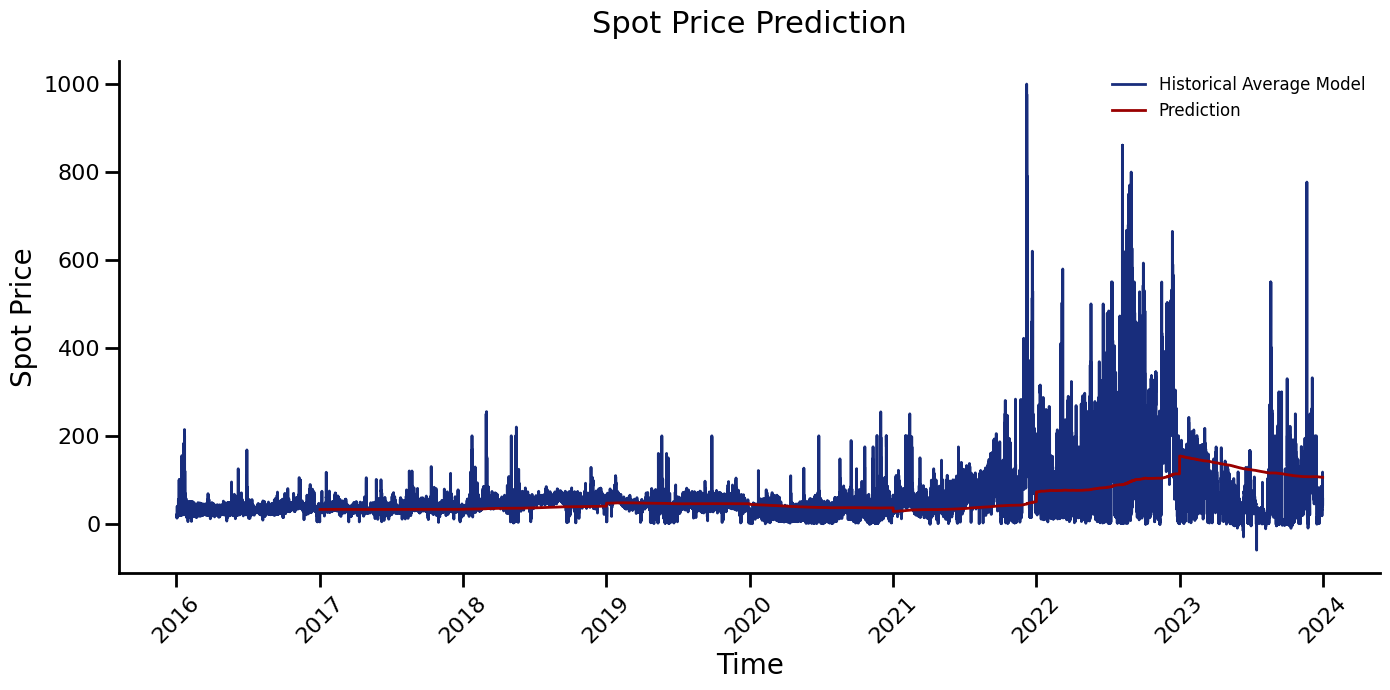

In [14]:
# Plot the predictions
plot_spot_price_predictions(df['y'], result_ha, 'Historical Average Model')

In [15]:
# Create a WindowAverageModel instance with a window size of 24 hours
wa = WindowAverageModel(window_size=horizon)
wa_predictions, wa_metrics = year_on_year_training(df, wa, refit=True)
predictions['Window Average'] = [{'predictions': wa_predictions}]
metrices['Window Average'] = wa_metrics
print(wa_metrics)

Training model for year 2016
Initial training completed with training size: 8784 Indexes: 2016-01-01 00:00:00+02:00 - 2016-12-31 23:00:00+02:00
Testing window 0: Indexes 2017-01-01 00:00:00+02:00 - 2017-01-01 23:00:00+02:00
Retrained model with updated training size: 8808 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-01 23:00:00+02:00
Testing window 1: Indexes 2017-01-02 00:00:00+02:00 - 2017-01-02 23:00:00+02:00
Retrained model with updated training size: 8832 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-02 23:00:00+02:00
Testing window 2: Indexes 2017-01-03 00:00:00+02:00 - 2017-01-03 23:00:00+02:00
Retrained model with updated training size: 8856 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-03 23:00:00+02:00
Testing window 3: Indexes 2017-01-04 00:00:00+02:00 - 2017-01-04 23:00:00+02:00
Retrained model with updated training size: 8880 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-04 23:00:00+02:00
Testing window 4: Indexes 2017-01-05 00:00:00+02:00 - 2017-01-05 23:00:00+02:00
Retraine

c:\Users\johwes\Repositories\Novia\spot-price-forecast\src\utils.py:731: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



Retrained model with updated training size: 9264 Indexes: 2018-01-01 00:00:00+02:00 - 2019-01-21 23:00:00+02:00
Testing window 21: Indexes 2019-01-22 00:00:00+02:00 - 2019-01-22 23:00:00+02:00
Retrained model with updated training size: 9288 Indexes: 2018-01-01 00:00:00+02:00 - 2019-01-22 23:00:00+02:00
Testing window 22: Indexes 2019-01-23 00:00:00+02:00 - 2019-01-23 23:00:00+02:00
Retrained model with updated training size: 9312 Indexes: 2018-01-01 00:00:00+02:00 - 2019-01-23 23:00:00+02:00
Testing window 23: Indexes 2019-01-24 00:00:00+02:00 - 2019-01-24 23:00:00+02:00
Retrained model with updated training size: 9336 Indexes: 2018-01-01 00:00:00+02:00 - 2019-01-24 23:00:00+02:00
Testing window 24: Indexes 2019-01-25 00:00:00+02:00 - 2019-01-25 23:00:00+02:00
Retrained model with updated training size: 9360 Indexes: 2018-01-01 00:00:00+02:00 - 2019-01-25 23:00:00+02:00
Testing window 25: Indexes 2019-01-26 00:00:00+02:00 - 2019-01-26 23:00:00+02:00
Retrained model with updated traini

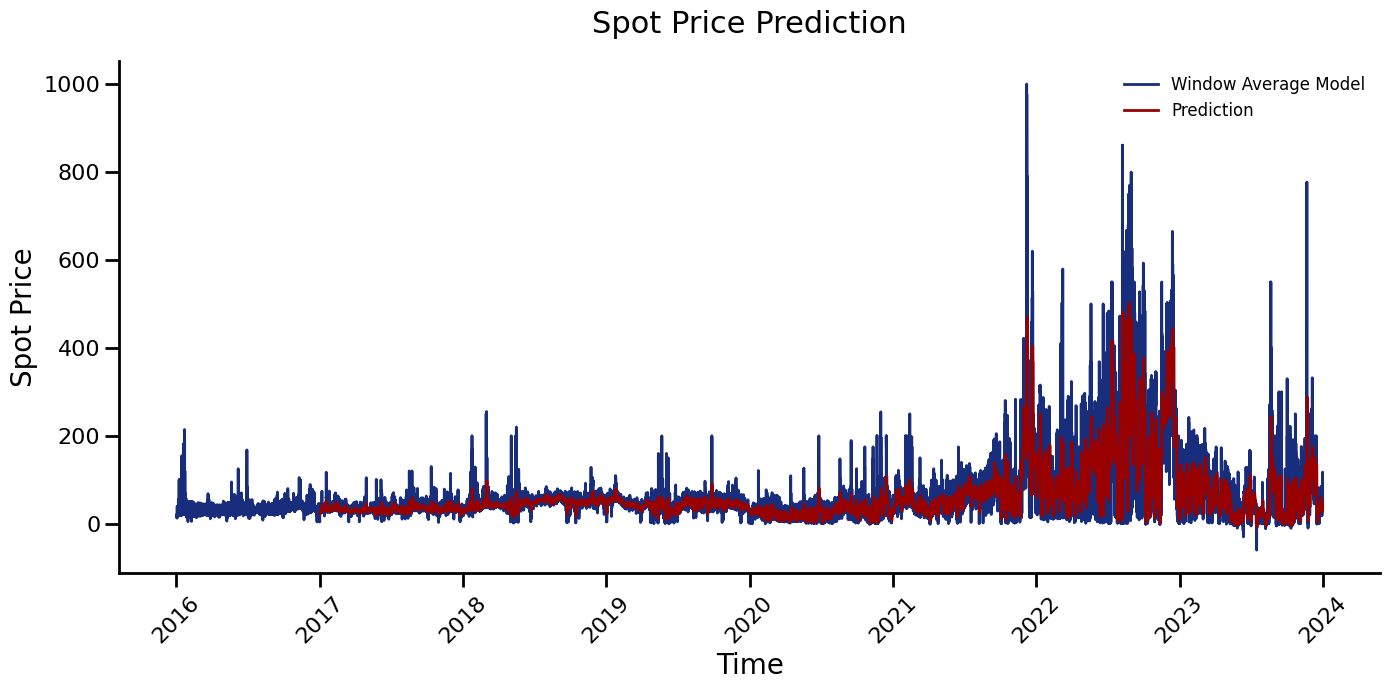

In [16]:
# Plot the predictions
plot_spot_price_predictions(df['y'], wa_predictions, 'Window Average Model')

In [17]:
ea = ExponentialAverage(alpha=0.2)
ea_predictions, ea_metrics = year_on_year_training(df, ea, refit=True)
predictions['Exponential Average'] = [{'predictions': ea_predictions}]
metrices['Exponential Average'] = ea_metrics
print(ea_metrics)

Training model for year 2016
Initial training completed with training size: 8784 Indexes: 2016-01-01 00:00:00+02:00 - 2016-12-31 23:00:00+02:00
Testing window 0: Indexes 2017-01-01 00:00:00+02:00 - 2017-01-01 23:00:00+02:00
Retrained model with updated training size: 8808 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-01 23:00:00+02:00
Testing window 1: Indexes 2017-01-02 00:00:00+02:00 - 2017-01-02 23:00:00+02:00
Retrained model with updated training size: 8832 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-02 23:00:00+02:00
Testing window 2: Indexes 2017-01-03 00:00:00+02:00 - 2017-01-03 23:00:00+02:00
Retrained model with updated training size: 8856 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-03 23:00:00+02:00
Testing window 3: Indexes 2017-01-04 00:00:00+02:00 - 2017-01-04 23:00:00+02:00
Retrained model with updated training size: 8880 Indexes: 2016-01-01 00:00:00+02:00 - 2017-01-04 23:00:00+02:00
Testing window 4: Indexes 2017-01-05 00:00:00+02:00 - 2017-01-05 23:00:00+02:00
Retraine

c:\Users\johwes\Repositories\Novia\spot-price-forecast\src\utils.py:731: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



Retrained model with updated training size: 14160 Indexes: 2017-01-01 00:00:00+02:00 - 2018-08-14 00:00:00+03:00
Testing window 225: Indexes 2018-08-14 01:00:00+03:00 - 2018-08-15 00:00:00+03:00
Retrained model with updated training size: 14184 Indexes: 2017-01-01 00:00:00+02:00 - 2018-08-15 00:00:00+03:00
Testing window 226: Indexes 2018-08-15 01:00:00+03:00 - 2018-08-16 00:00:00+03:00
Retrained model with updated training size: 14208 Indexes: 2017-01-01 00:00:00+02:00 - 2018-08-16 00:00:00+03:00
Testing window 227: Indexes 2018-08-16 01:00:00+03:00 - 2018-08-17 00:00:00+03:00
Retrained model with updated training size: 14232 Indexes: 2017-01-01 00:00:00+02:00 - 2018-08-17 00:00:00+03:00
Testing window 228: Indexes 2018-08-17 01:00:00+03:00 - 2018-08-18 00:00:00+03:00
Retrained model with updated training size: 14256 Indexes: 2017-01-01 00:00:00+02:00 - 2018-08-18 00:00:00+03:00
Testing window 229: Indexes 2018-08-18 01:00:00+03:00 - 2018-08-19 00:00:00+03:00
Retrained model with upda

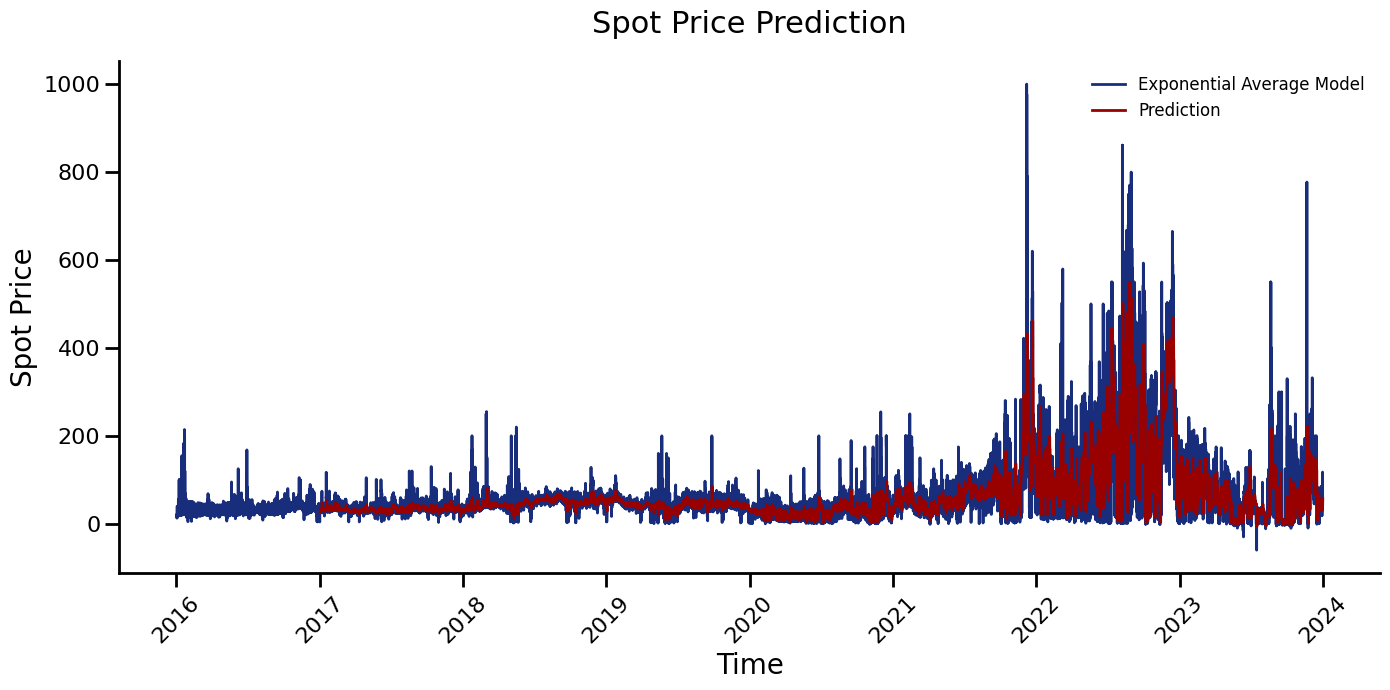

In [18]:
# Plot the predictions
plot_spot_price_predictions(df['y'], ea_predictions, 'Exponential Average Model')

#### **3.2. Linear Regression with Time Component**

In [19]:
df_time = extract_time_features(df)

In [20]:
# Linear regression
lr_time_features = LinearRegression(fit_intercept=False)

# year on year training
lr_time_predictions, lr_time_metrics, lr_time_features_coeffs = year_on_year_training(df_time, lr_time_features)
predictions['LR (Time Component)'] = [{'predictions' :lr_time_predictions}]
metrices['LR (Time Component)'] = lr_time_metrics

Training model for year 2016
Initial training completed with training size: 8784 Indexes: 2016-01-01 00:00:00+02:00 - 2016-12-31 23:00:00+02:00
Testing window 0: Indexes 2017-01-01 00:00:00+02:00 - 2017-01-01 23:00:00+02:00
Testing window 1: Indexes 2017-01-02 00:00:00+02:00 - 2017-01-02 23:00:00+02:00
Testing window 2: Indexes 2017-01-03 00:00:00+02:00 - 2017-01-03 23:00:00+02:00
Testing window 3: Indexes 2017-01-04 00:00:00+02:00 - 2017-01-04 23:00:00+02:00
Testing window 4: Indexes 2017-01-05 00:00:00+02:00 - 2017-01-05 23:00:00+02:00
Testing window 5: Indexes 2017-01-06 00:00:00+02:00 - 2017-01-06 23:00:00+02:00
Testing window 6: Indexes 2017-01-07 00:00:00+02:00 - 2017-01-07 23:00:00+02:00
Testing window 7: Indexes 2017-01-08 00:00:00+02:00 - 2017-01-08 23:00:00+02:00
Testing window 8: Indexes 2017-01-09 00:00:00+02:00 - 2017-01-09 23:00:00+02:00
Testing window 9: Indexes 2017-01-10 00:00:00+02:00 - 2017-01-10 23:00:00+02:00
Testing window 10: Indexes 2017-01-11 00:00:00+02:00 - 2

c:\Users\johwes\Repositories\Novia\spot-price-forecast\src\utils.py:731: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



Initial training completed with training size: 8760 Indexes: 2017-01-01 00:00:00+02:00 - 2017-12-31 23:00:00+02:00
Testing window 0: Indexes 2018-01-01 00:00:00+02:00 - 2018-01-01 23:00:00+02:00
Testing window 1: Indexes 2018-01-02 00:00:00+02:00 - 2018-01-02 23:00:00+02:00
Testing window 2: Indexes 2018-01-03 00:00:00+02:00 - 2018-01-03 23:00:00+02:00
Testing window 3: Indexes 2018-01-04 00:00:00+02:00 - 2018-01-04 23:00:00+02:00
Testing window 4: Indexes 2018-01-05 00:00:00+02:00 - 2018-01-05 23:00:00+02:00
Testing window 5: Indexes 2018-01-06 00:00:00+02:00 - 2018-01-06 23:00:00+02:00
Testing window 6: Indexes 2018-01-07 00:00:00+02:00 - 2018-01-07 23:00:00+02:00
Testing window 7: Indexes 2018-01-08 00:00:00+02:00 - 2018-01-08 23:00:00+02:00
Testing window 8: Indexes 2018-01-09 00:00:00+02:00 - 2018-01-09 23:00:00+02:00
Testing window 9: Indexes 2018-01-10 00:00:00+02:00 - 2018-01-10 23:00:00+02:00
Testing window 10: Indexes 2018-01-11 00:00:00+02:00 - 2018-01-11 23:00:00+02:00
Test

{'mean_squared_error': 6056.719869080114, 'mean_absolute_error': 42.3694995489767, 'root_mean_squared_error': 77.82493089672559}


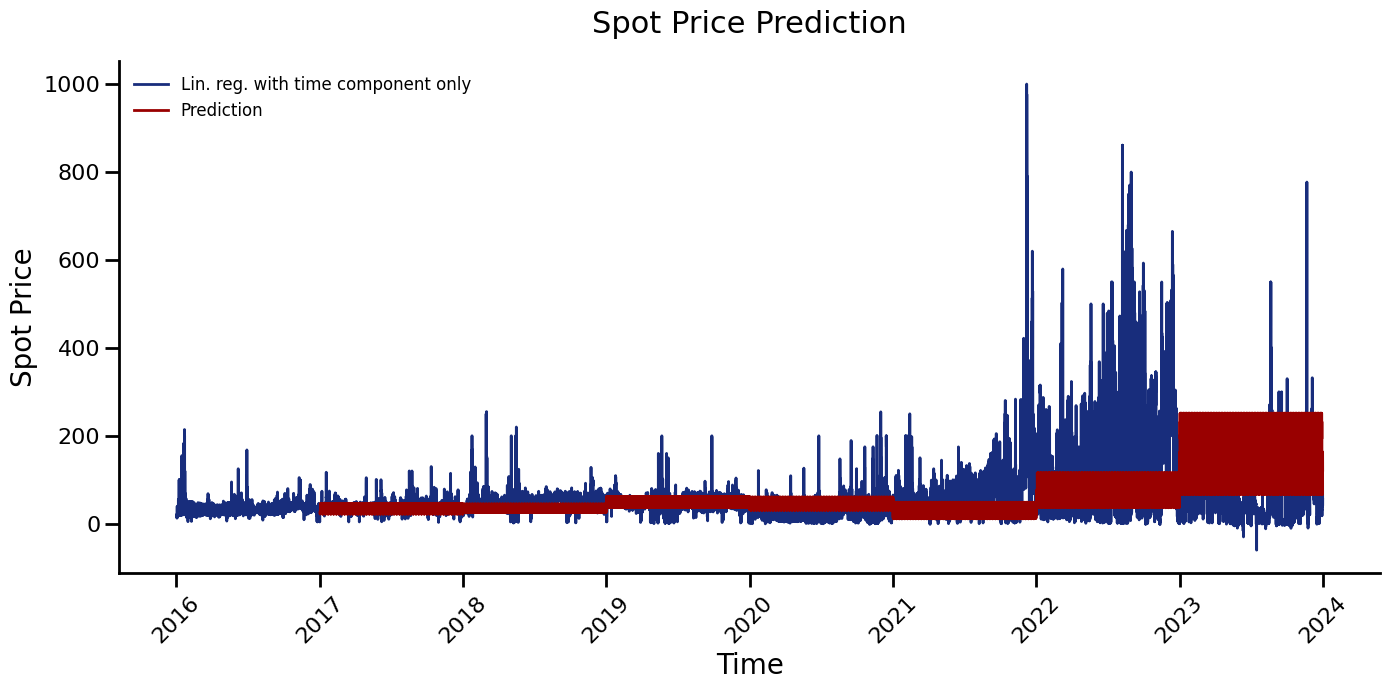

In [22]:
print(lr_time_metrics)
# Plot the predictions
plot_spot_price_predictions(df['y'], lr_time_predictions, 'Lin. reg. with time component only')

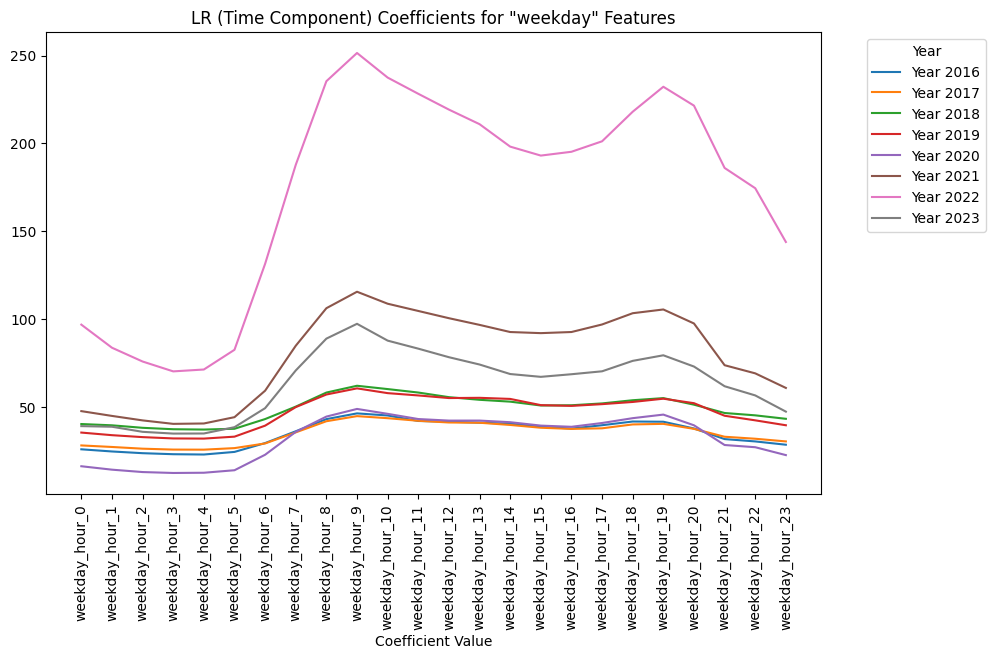

In [18]:
plot_year_over_year_coefficients(lr_time_features_coeffs, keyword="weekday", model_name='LR (Time Component)')

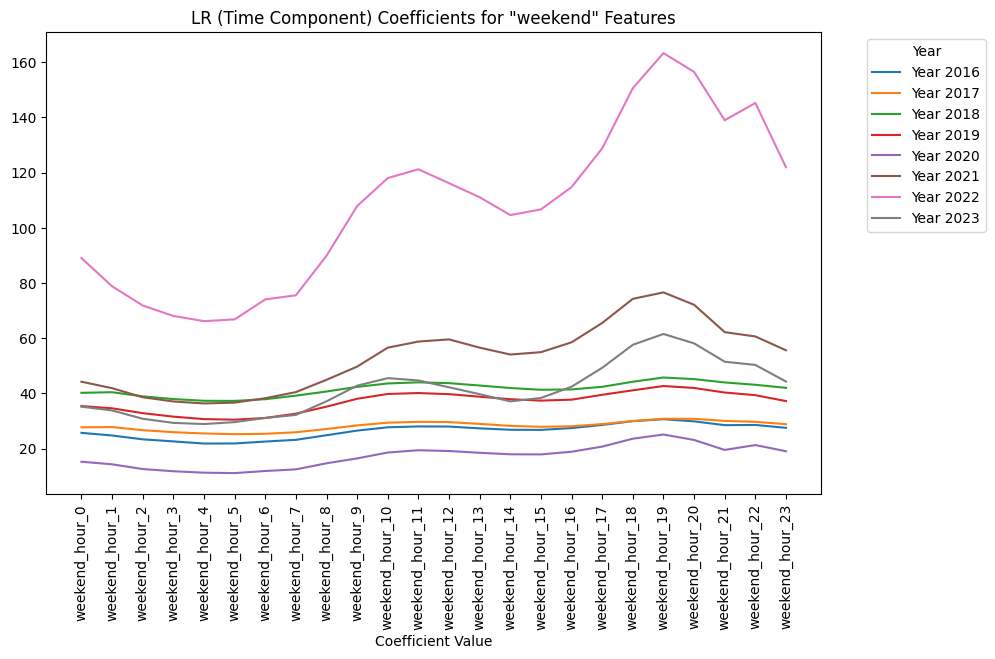

In [19]:
plot_year_over_year_coefficients(lr_time_features_coeffs, keyword="weekend", model_name='LR (Time Component)')

#### **3.3. Download External Features from Fingrid**

Note: Uncomment the code to download the external features from Fingrid.

In [21]:
# Get the available data types
datasets = fetch_data("datasets", params = {'pageSize': 20000, 'orderBy': 'id'})

{'total': 199, 'lastPage': 1, 'prevPage': None, 'nextPage': None, 'perPage': 20000, 'currentPage': 1, 'from': 0, 'to': 199} dict_keys(['data', 'pagination'])


In [22]:
# Get the dataset infrormation and descriptions
for dataset in datasets:
    print(f"{dataset['id']} - {dataset['nameEn']} ({dataset['dataPeriodEn']})")
    print("Description:", dataset['descriptionEn'])
    print("-"*20)

1 - Automatic Frequency Restoration Reserve, capacity, up (1 h)
Description: Procured automatic Frequency Restoration Reserve (aFRR) capacity, up [MW]
--------------------
2 - Automatic Frequency Restoration Reserve, capacity, down (1 h)
Description: Procured automatic Frequency Restoration Reserve (aFRR) capacity, down [MW]
--------------------
22 - Price of the last activated up-regulation bid - real time data (1 h)
Description: The price of the last activated up-regulation bid. The price is published real-time when Finland is a separate regulation area. Finland is an own separate regulation area in a situation where the border transmission connections between Finland and the Nordic countries are fully operational, which means that no more balancing energy can be imported from the other Nordic countries. In this case, only Finnish offers can be used. The balancing energy market is used to balance electricity production and consumption in real time. Fingrid orders up- or down-regulati

In [ ]:
# download datasets by id
start_time = df.index[0].strftime('%Y-%m-%dT%H:%M:%S.000Z')
end_time = df.index[-1].strftime('%Y-%m-%dT%H:%M:%S.000Z')
# dataset_ids = ['165', '242', '246', '247']
dataset_ids = ['247']
for dataset_id in dataset_ids:
    # check if dataset is already downloaded
    if os.path.exists(f'../data/{dataset_id}.csv'):
        print(f'Dataset {dataset_id} already downloaded.')
        print("-"*20)
        continue
    try:
        data = fetch_data("data", params = {'datasets': dataset_id, 'startTime': start_time, 'endTime': end_time, 'format': 'json', 'oneRowPerTimePeriod': 'true', 'pageSize': 20000, 'locale': 'en', 'sortBy': 'startTime', 'sortOrder': 'asc'})
    except Exception as e:
        print(f"Error fetching dataset {dataset_id}: {e}")
        print("-"*20)
        continue

    # convert data to dataframe
    data = pd.DataFrame(data)
    data['startTime'] = pd.to_datetime(data['startTime'])
    data.set_index('startTime', inplace=True)
    # drop endTime
    data.drop(columns='endTime', inplace=True)
    data.sort_index(inplace=True)
    # localize index to none
    data.index = data.index.tz_localize(None)
    print(f'Dataset {dataset_id} length:', len(data))
    print("-"*20)
    data.to_csv(f'../data/{dataset_id}.csv')
    time.sleep(60)

Dataset 165 already downloaded.
--------------------
Dataset 242 already downloaded.
--------------------
Dataset 246 already downloaded.
--------------------
{'total': 59737, 'lastPage': 3, 'prevPage': None, 'nextPage': 2, 'perPage': 20000, 'currentPage': 1, 'from': 0, 'to': 20000} dict_keys(['data', 'pagination'])
Error fetching dataset 247: 429 Client Error: Too Many Requests for url: https://data.fingrid.fi/api/data?datasets=247&startTime=2016-01-01T00%3A00%3A00.000Z&endTime=2023-12-31T23%3A00%3A00.000Z&format=json&oneRowPerTimePeriod=true&pageSize=20000&locale=en&sortBy=startTime&sortOrder=asc&page=2
--------------------


#### **3.4. Time + External Features**

In [24]:
features_to_add = ['246', '247', '165', '242'] # ids of the previously downloaded dataset
len_ext_features = len(features_to_add) 
df_ext_features = add_external_features(df_time, features_to_add)

In [25]:
# rename column name
df_ext_features.rename(
    {'Electricity production prediction - premilinary': 'electricity_production_forecast',
     'Electricity consumption forecast - next 24 hours': 'electricity_consumption_forecast',
     'Solar power generation forecast - updated once a day': 'solar_power_generation_forecast',
     'Wind power generation forecast - updated once a day': 'wind_power_generation_forecast'}, axis=1, inplace=True)

In [ ]:
# plot external variables
fig = go.Figure()
for col in df_ext_features.columns[-len_ext_features:]:
    fig.add_trace(go.Scatter(x=df_ext_features.index, y=df_ext_features[col], mode='lines', name=col))
# add zoom
fig.update_layout(xaxis_rangeslider_visible=True)
fig.update_layout(title='External Features Over Time', xaxis_title='Time', yaxis_title='Feature Value')
fig.show()

In [27]:
# fill missing values with given fill functions
missing_mapping = {
    'electricity_consumption_forecast': ['ffill','bfill'],
    'electricity_production_forecast': ['ffill','bfill'],
    'wind_power_generation_forecast': ['ffill','bfill'],
    'solar_power_generation_forecast': ['interpolate','bfill','ffill'],
}

df_ext_features = fill_missing_values(df_ext_features, missing_mapping)

In [ ]:
# plot external variables
fig = go.Figure()
for col in df_ext_features.columns[-len_ext_features:]:
    fig.add_trace(go.Scatter(x=df_ext_features.index, y=df_ext_features[col], mode='lines', name=col))
# add zoom
fig.update_layout(xaxis_rangeslider_visible=True)
fig.update_layout(title='External Features Over Time', xaxis_title='Time', yaxis_title='Feature Value')
fig.show()

In [ ]:
# check missing values
print(df_ext_features.isnull().sum())

In [ ]:
# Linear regression
lr_ext = LinearRegression(fit_intercept=False)

# year on year training
lr_ext_predictions, lr_ext_metrics, lr_ext_features_coeffs = year_on_year_training(df_ext_features, lr_ext)
predictions['LR (Time + External Features)'] = [{'predictions' :lr_ext_predictions}]
metrices['LR (Time + External Features)'] = lr_ext_metrics

In [ ]:
print(lr_ext_metrics)

In [ ]:
model = LinearRegression(fit_intercept=False)
plot_year_over_year_coefficients(lr_ext_features_coeffs, keyword="weekday")

In [ ]:
# Plot weekend coefficients
plot_year_over_year_coefficients(lr_ext_features_coeffs, keyword="weekend")

In [ ]:
# plot electricity production forecast
plot_year_over_year_coefficients(lr_ext_features_coeffs, keyword="electricity_production_forecast")

In [ ]:
# plot electricity consumption forecast
plot_year_over_year_coefficients(lr_ext_features_coeffs, keyword="electricity_consumption_forecast")

In [ ]:
# plot wind power generation forecast
plot_year_over_year_coefficients(lr_ext_features_coeffs, keyword="wind_power_generation_forecast")

In [ ]:
# plot solar power generation forecast
plot_year_over_year_coefficients(lr_ext_features_coeffs, keyword="solar_power_generation_forecast")

#### **3.5. With LEAR Features**

[LEAR Paper](https://www.sciencedirect.com/science/article/pii/S0306261921004529?via%3Dihub)

##### **3.5.1. Time + Price Lags**

In [24]:
# List of lags for historical prices and forecasts
price_lags = [1, 2, 3, 7]

# Creating lag features for day-ahead prices
df_lear_price = create_daily_lag_features(df_time, 'y', price_lags, average=True)

df_lear_price = df_lear_price.copy() # avoiding fragmentation


In [25]:
df_lear_price

y  weekday_hour_0  weekend_hour_0  \
date                                                               
2016-01-01 00:00:00+02:00  15.91               1               0   
2016-01-01 01:00:00+02:00  16.39               0               0   
2016-01-01 02:00:00+02:00  16.04               0               0   
2016-01-01 03:00:00+02:00  15.74               0               0   
2016-01-01 04:00:00+02:00  15.57               0               0   
...                          ...             ...             ...   
2023-12-31 19:00:00+02:00  97.62               0               0   
2023-12-31 20:00:00+02:00  59.99               0               0   
2023-12-31 21:00:00+02:00  40.99               0               0   
2023-12-31 22:00:00+02:00  53.83               0               0   
2023-12-31 23:00:00+02:00  55.49               0               0   

                           weekday_hour_1  weekend_hour_1  weekday_hour_2  \
date                                                                        
2016-01-01 00:00:00+02:00               0               0               0   
2016-01-01 01:00:00+02:00               1               0               0   
2016-01-01 02:00:00+02:00               0               0               1   
2016-01-01 03:00:00+02:00               0               0               0   
2016-01-01 04:00:00+02:00               0               0               0   
...                                   ...             ...             ...   
2023-12-31 19:00:00+02:00               0               0               0   
2023-12-31 20:00:00+02:00               0               0               0   
2023-12-31 21:00:00+02:00               0               0               0   
2023-12-31 22:00:00+02:00               0               0               0   
2023-12-31 23:00:00+02:00               0               0               0   

                           weekend_hour_2  weekday_hour_3  weekend_hour_3  \
date                                                                        
2016-01-01 00:00:00+02:00               0               0               0   
2016-01-01 01:00:00+02:00               0               0               0   
2016-01-01 02:00:00+02:00               0               0               0   
2016-01-01 03:00:00+02:00               0               1               0   
2016-01-01 04:00:00+02:00               0               0               0   
...                                   ...             ...             ...   
2023-12-31 19:00:00+02:00               0               0               0   
2023-12-31 20:00:00+02:00               0               0               0   
2023-12-31 21:00:00+02:00               0               0               0   
2023-12-31 22:00:00+02:00               0               0               0   
2023-12-31 23:00:00+02:00               0               0               0   

                           weekday_hour_4  ...  weekday_hour_21  \
date                                       ...                    
2016-01-01 00:00:00+02:00               0  ...                0   
2016-01-01 01:00:00+02:00               0  ...                0   
2016-01-01 02:00:00+02:00               0  ...                0   
2016-01-01 03:00:00+02:00               0  ...                0   
2016-01-01 04:00:00+02:00               1  ...                0   
...                                   ...  ...              ...   
2023-12-31 19:00:00+02:00               0  ...                0   
2023-12-31 20:00:00+02:00               0  ...                0   
2023-12-31 21:00:00+02:00               0  ...                0   
2023-12-31 22:00:00+02:00               0  ...                0   
2023-12-31 23:00:00+02:00               0  ...                0   

                           weekend_hour_21  weekday_hour_22  weekend_hour_22  \
date                                                                           
2016-01-01 00:00:00+02:00                0                0                0   
2016-01-01 01:00:00+02:00     

In [26]:
# Verifying the number of features
print(f'Total number of features: {len(df_lear_price.columns)}')

Total number of features: 53


In [27]:
print(df_lear_price.columns.to_list())

['y', 'weekday_hour_0', 'weekend_hour_0', 'weekday_hour_1', 'weekend_hour_1', 'weekday_hour_2', 'weekend_hour_2', 'weekday_hour_3', 'weekend_hour_3', 'weekday_hour_4', 'weekend_hour_4', 'weekday_hour_5', 'weekend_hour_5', 'weekday_hour_6', 'weekend_hour_6', 'weekday_hour_7', 'weekend_hour_7', 'weekday_hour_8', 'weekend_hour_8', 'weekday_hour_9', 'weekend_hour_9', 'weekday_hour_10', 'weekend_hour_10', 'weekday_hour_11', 'weekend_hour_11', 'weekday_hour_12', 'weekend_hour_12', 'weekday_hour_13', 'weekend_hour_13', 'weekday_hour_14', 'weekend_hour_14', 'weekday_hour_15', 'weekend_hour_15', 'weekday_hour_16', 'weekend_hour_16', 'weekday_hour_17', 'weekend_hour_17', 'weekday_hour_18', 'weekend_hour_18', 'weekday_hour_19', 'weekend_hour_19', 'weekday_hour_20', 'weekend_hour_20', 'weekday_hour_21', 'weekend_hour_21', 'weekday_hour_22', 'weekend_hour_22', 'weekday_hour_23', 'weekend_hour_23', 'y_lag_avg_1', 'y_lag_avg_2', 'y_lag_avg_3', 'y_lag_avg_7']


In [28]:
df_lear_price.dropna(inplace=True)

###### **3.5.1.1 Evaluate on Test Set**

In [29]:
lear_price = LinearRegression(fit_intercept=False)
lear_price_predictions, lear_price_metrics, lear_price_coeffs = year_on_year_training(df_lear_price, lear_price)
predictions['LR (Time + Price Lags)'] = [{'predictions': lear_price_predictions}]
metrices['LR (Time + Price Lags)'] = lear_price_metrics

Training model for year 2016
Initial training completed with training size: 8616 Indexes: 2016-01-08 00:00:00+02:00 - 2016-12-31 23:00:00+02:00
Testing window 0: Indexes 2017-01-01 00:00:00+02:00 - 2017-01-01 23:00:00+02:00
Testing window 1: Indexes 2017-01-02 00:00:00+02:00 - 2017-01-02 23:00:00+02:00
Testing window 2: Indexes 2017-01-03 00:00:00+02:00 - 2017-01-03 23:00:00+02:00
Testing window 3: Indexes 2017-01-04 00:00:00+02:00 - 2017-01-04 23:00:00+02:00
Testing window 4: Indexes 2017-01-05 00:00:00+02:00 - 2017-01-05 23:00:00+02:00
Testing window 5: Indexes 2017-01-06 00:00:00+02:00 - 2017-01-06 23:00:00+02:00
Testing window 6: Indexes 2017-01-07 00:00:00+02:00 - 2017-01-07 23:00:00+02:00
Testing window 7: Indexes 2017-01-08 00:00:00+02:00 - 2017-01-08 23:00:00+02:00
Testing window 8: Indexes 2017-01-09 00:00:00+02:00 - 2017-01-09 23:00:00+02:00
Testing window 9: Indexes 2017-01-10 00:00:00+02:00 - 2017-01-10 23:00:00+02:00
Testing window 10: Indexes 2017-01-11 00:00:00+02:00 - 2

c:\Users\johwes\Repositories\Novia\spot-price-forecast\src\utils.py:731: FutureWarning:

The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.



Testing window 81: Indexes 2018-03-23 00:00:00+02:00 - 2018-03-23 23:00:00+02:00
Testing window 82: Indexes 2018-03-24 00:00:00+02:00 - 2018-03-24 23:00:00+02:00
Testing window 83: Indexes 2018-03-25 00:00:00+02:00 - 2018-03-26 00:00:00+03:00
Testing window 84: Indexes 2018-03-26 01:00:00+03:00 - 2018-03-27 00:00:00+03:00
Testing window 85: Indexes 2018-03-27 01:00:00+03:00 - 2018-03-28 00:00:00+03:00
Testing window 86: Indexes 2018-03-28 01:00:00+03:00 - 2018-03-29 00:00:00+03:00
Testing window 87: Indexes 2018-03-29 01:00:00+03:00 - 2018-03-30 00:00:00+03:00
Testing window 88: Indexes 2018-03-30 01:00:00+03:00 - 2018-03-31 00:00:00+03:00
Testing window 89: Indexes 2018-03-31 01:00:00+03:00 - 2018-04-01 00:00:00+03:00
Testing window 90: Indexes 2018-04-01 01:00:00+03:00 - 2018-04-02 00:00:00+03:00
Testing window 91: Indexes 2018-04-02 01:00:00+03:00 - 2018-04-03 00:00:00+03:00
Testing window 92: Indexes 2018-04-03 01:00:00+03:00 - 2018-04-04 00:00:00+03:00
Testing window 93: Indexes 2

{'mean_squared_error': 2153.2529024991004, 'mean_absolute_error': 24.0576473563693, 'root_mean_squared_error': 46.40315616958722}


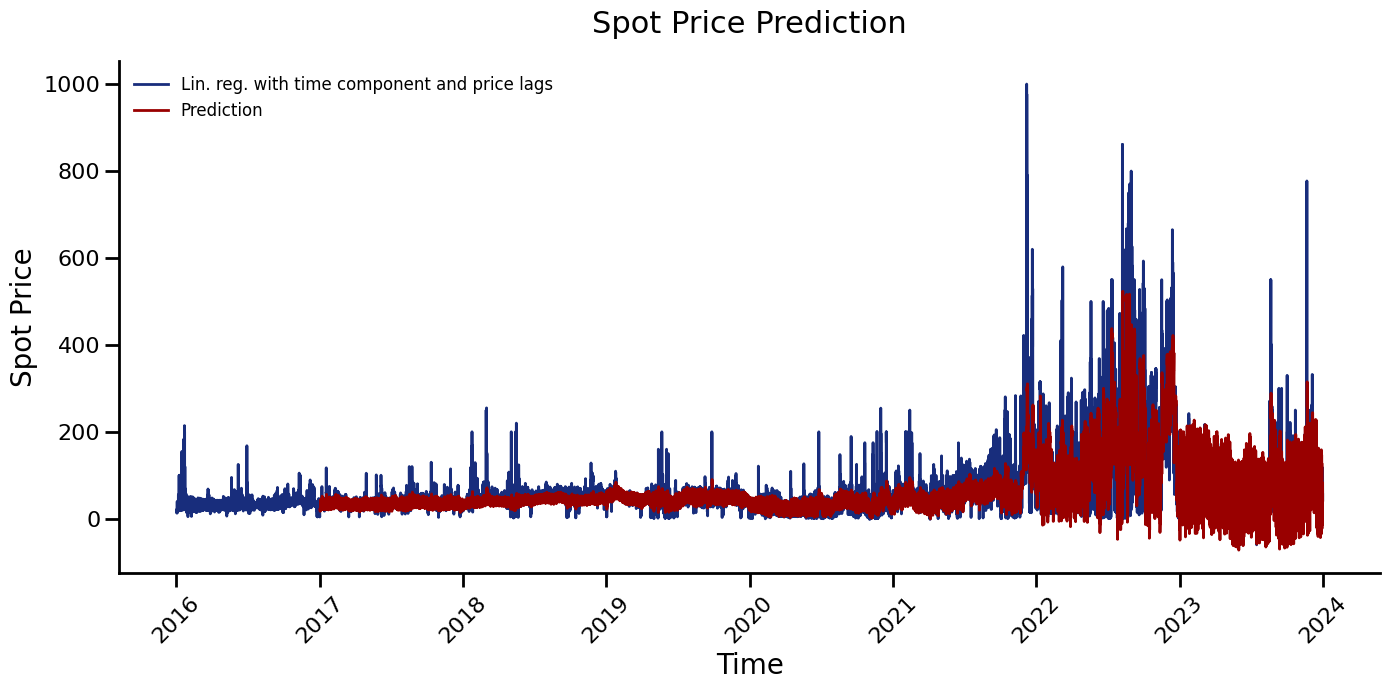

In [33]:
print(lear_price_metrics)
# Plot the predictions
plot_spot_price_predictions(df['y'], lear_price_predictions, 'Lin. reg. with time component and price lags')

In [31]:
col_names = ["y_lag", "electricity_production", "electricity_consumption", "wind_power", "solar_power"]

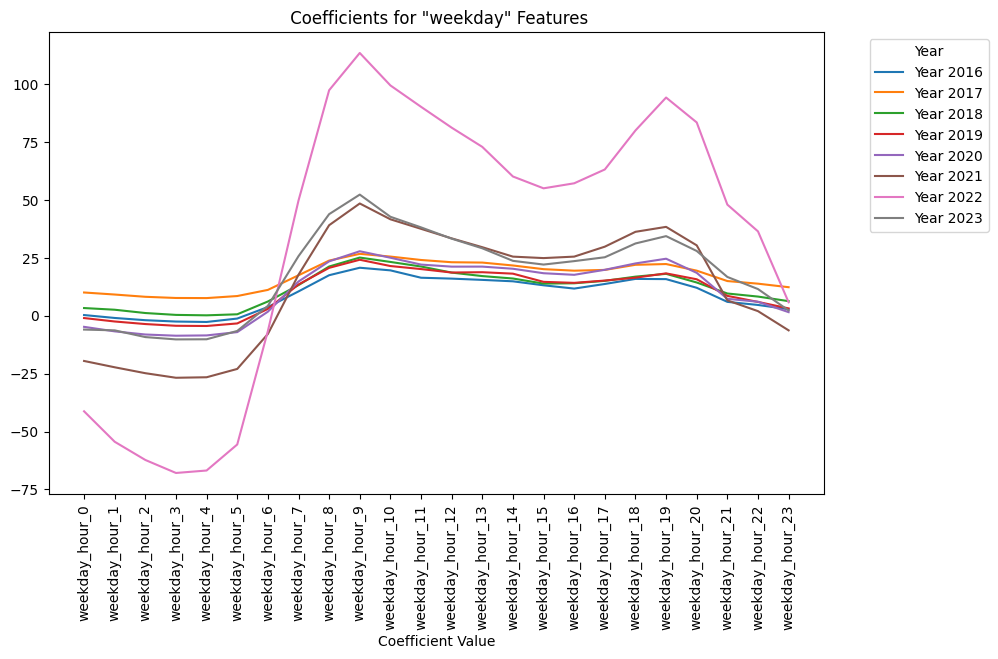

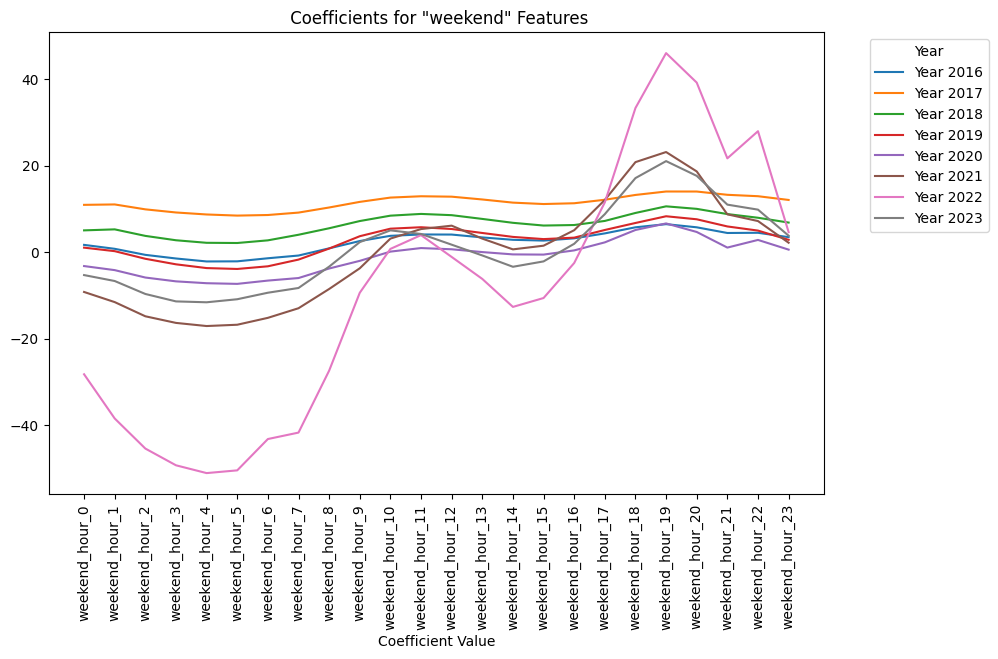

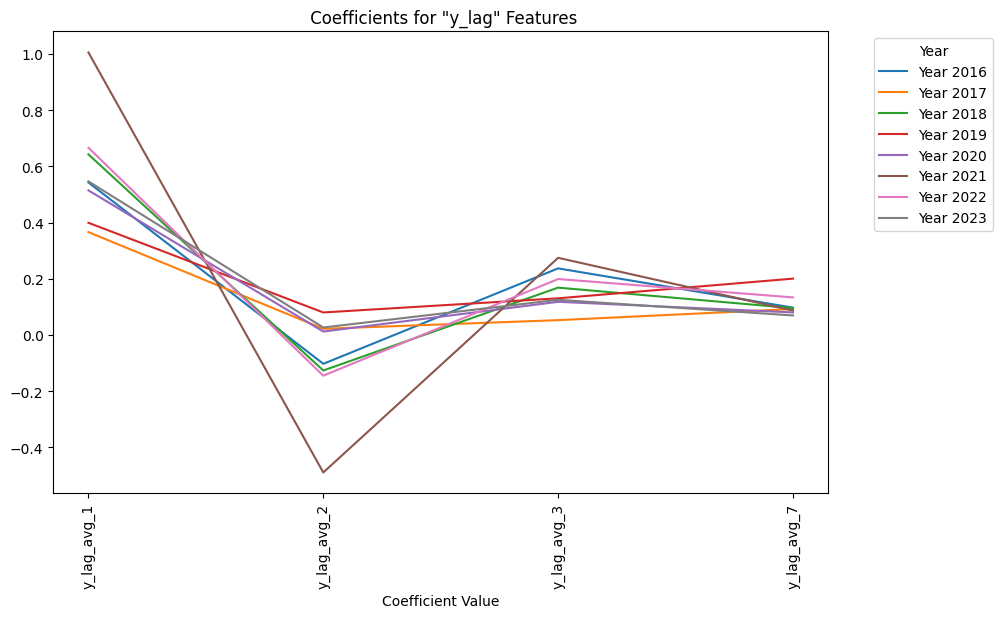

In [32]:
col_names = ["weekday", "weekend", "y_lag"]

for col in col_names:
    plot_year_over_year_coefficients(lear_price_coeffs, keyword=col)

###### **3.5.1.2 Evaluate on Training Set**

In [ ]:
lear_price_train = LinearRegression(fit_intercept=False)
lear_price_predictions_train, lear_price_metrics_train, lear_price_coeffs_train = year_on_year_training(df_lear_price, lear_price_train, eval_train=True)
predictions_train['LR (Time + Price Lags)'] = [{'predictions': lear_price_predictions_train}]
metrices_train['LR (Time + Price Lags)'] = lear_price_metrics_train

In [ ]:
print(lear_price_metrics_train)

##### **3.5.2. Time + Price Lags + External Features**

In [18]:
# external features ids 
features_to_add = ['246', '247', '165', '242'] # ids of the previously downloaded dataset

# add external features
df_lear_price_ext = add_external_features(df_lear_price, features_to_add)

In [19]:
df_lear_price_ext.rename(
    {'Electricity production prediction - premilinary': 'electricity_production_forecast',
     'Electricity consumption forecast - next 24 hours': 'electricity_consumption_forecast',
     'Solar power generation forecast - updated once a day': 'solar_power_generation_forecast',
     'Wind power generation forecast - updated once a day': 'wind_power_generation_forecast'}, axis=1, inplace=True)

In [20]:
# missing values mapping
missing_mapping = {
    'electricity_consumption_forecast': ['ffill','bfill'],
    'electricity_production_forecast': ['ffill','bfill'],
    'wind_power_generation_forecast': ['ffill','bfill'],
    'solar_power_generation_forecast': ['interpolate','bfill','ffill'],
}

# fill missing values
df_lear_price_ext = fill_missing_values(df_lear_price_ext, missing_mapping)

###### **3.5.2.1 Evaluate on Test Set**

In [ ]:
# Linear regression
lear_price_ext = LinearRegression(fit_intercept=False)

# year on year training
lear_price_ext_predictions, lear_price_ext_metrics, lear_price_ext_features_coeffs = year_on_year_training(df_lear_price_ext, lear_price_ext)
predictions['LR (Time + Price Lags + External Features)'] = [{'predictions': lear_price_ext_predictions}]
metrices['LR (Time + Price Lags + External Features)'] = lear_price_ext_metrics

In [ ]:
print(lear_price_ext_metrics)

In [ ]:
cols = ["weekend", "weekday", 'y_lag', 'electricity_production_forecast', 'electricity_consumption_forecast', 'wind_power_generation_forecast', 'solar_power_generation_forecast']

for col in cols:
    plot_year_over_year_coefficients(lear_price_ext_features_coeffs, keyword=col)

###### **3.5.2.2 Evaluate on Training Set**

In [ ]:
# Linear regression
lear_price_ext_train = LinearRegression(fit_intercept=False)

# year on year training
lear_price_ext_predictions_train, lear_price_ext_metrics_train, lear_price_ext_features_coeffs_train = year_on_year_training(df_lear_price_ext, lear_price_ext_train, eval_train=True)
predictions_train['LR (Time + Price Lags + External Features)'] = [{'predictions': lear_price_ext_predictions_train}]
metrices_train['LR (Time + Price Lags + External Features)'] = lear_price_ext_metrics_train

In [ ]:
print(lear_price_ext_metrics_train)

##### **3.5.3. Time + Price Lags + External Features + External Lags**

In [26]:
# forecast lags
forecast_lags = [1, 7]

# Creating lag features for electricity production forecast
df_lear_price_ext_extlags = create_daily_lag_features(df_lear_price_ext, 'electricity_production_forecast', forecast_lags, average=True)

# Creating lag features for electricity consumption forecast
df_lear_price_ext_extlags = create_daily_lag_features(df_lear_price_ext_extlags, 'electricity_consumption_forecast', forecast_lags, average=True)

# Creating lag features for wind power generation forecast
df_lear_price_ext_extlags = create_daily_lag_features(df_lear_price_ext_extlags, 'wind_power_generation_forecast', forecast_lags, average=True)

# Creating lag features for solar power generation forecast
df_lear_price_ext_extlags = create_daily_lag_features(df_lear_price_ext_extlags, 'solar_power_generation_forecast', forecast_lags, average=True)

In [ ]:
# print out the columns
print(df_lear_price_ext_extlags.columns.to_list())

In [28]:
# drop missing values
df_lear_price_ext_extlags.dropna(inplace=True)

###### **3.5.3.1 Evaluate on Test Set**

In [ ]:
# Linear regression
lear_price_ext_extlags = LinearRegression(fit_intercept=False)

# year on year training
lear_price_ext_extlags_predictions, lear_price_ext_extlags_metrics, lear_price_ext_extlags_features_coeffs = year_on_year_training(df_lear_price_ext_extlags, lear_price_ext_extlags)
predictions['LR (Time + Price Lags + External Features + External Lags)'] = [{'predictions': lear_price_ext_extlags_predictions}]
metrices['LR (Time + Price Lags + External Features + External Lags)'] = lear_price_ext_extlags_metrics

In [ ]:
print(lear_price_ext_extlags_metrics)

In [ ]:
# select index that do not contain 'lag'
lear_price_ext_extlags_features_coeffs[2016].index[~lear_price_ext_extlags_features_coeffs[2016].index.str.contains('lag')]

In [ ]:
# plot coefficients
cols = ["weekend", "weekday", 'y_lag', 'electricity_production_forecast', 'electricity_consumption_forecast', 'wind_power_generation_forecast', 'solar_power_generation_forecast']

# filter coeffs without forecast_lag index
lear_price_ext_extlags_features_coeffs_ = {year: coeffs[coeffs.index[~coeffs.index.str.contains('forecast_lag')]] for year, coeffs in lear_price_ext_extlags_features_coeffs.items()}

for col in cols:
    plot_year_over_year_coefficients(lear_price_ext_extlags_features_coeffs_, keyword=col, years=[2023])

In [ ]:
# plot indexes with 'weekend' and 'weekday' coeffs for 2023 in the same graph
plt.figure(figsize=(12, 6))
weekend_coeffs = lear_price_ext_extlags_features_coeffs_[2023].loc[lear_price_ext_extlags_features_coeffs_[2023].index.str.contains('weekend')]
weekday_coeffs = lear_price_ext_extlags_features_coeffs_[2023].loc[lear_price_ext_extlags_features_coeffs_[2023].index.str.contains('weekday')]
plt.plot(range(24), weekend_coeffs.values, label='weekend')
plt.plot(range(24), weekday_coeffs.values, label='weekday')
plt.xlabel('Hour of the Day')
plt.ylabel('Coefficient Value')
plt.title("Coefficients for 'weekend' and 'weekday' Features in 2023")
plt.legend()
plt.xticks(range(24))
plt.show()

###### **3.5.3.2 Evaluate on Training Set**

In [ ]:
# Linear regression
lear_price_ext_extlags_train = LinearRegression(fit_intercept=False)

# year on year training
lear_price_ext_extlags_predictions_train, lear_price_ext_extlags_metrics_train, lear_price_ext_extlags_features_coeffs_train = year_on_year_training(df_lear_price_ext_extlags, lear_price_ext_extlags_train, eval_train=True)
predictions_train['LR (Time + Price Lags + External Features + External Lags)'] = [{'predictions': lear_price_ext_extlags_predictions_train}]
metrices_train['LR (Time + Price Lags + External Features + External Lags)'] = lear_price_ext_extlags_metrics_train

In [ ]:
print(lear_price_ext_extlags_metrics_train)

# **4. Visualization**

#### **4.1. Visualization of Predictions**

In [ ]:
plot_predictions(predictions, df['y'])

In [ ]:
plot_mae(predictions, df['y'])

In [ ]:
plot_metrics(metrices)

In [ ]:
# print mae for each model sorted by mean_squared_error
for key, value in sorted(metrices.items(), key=lambda x: x[1]['mean_squared_error']):
    print(f'{key}: {value["mean_squared_error"]}')

In [ ]:
app = visualize_predictions(spot_data, predictions)

# run app and also show url
app.run_server(debug=True, use_reloader=False, jupyter_mode="external")

#### **4.2. Visualization of Predictions Frequencies**

In [46]:
# remove simple baseline models from predictions for visualization
predictions = {key: value for key, value in predictions.items() if 'LR' in key}

# also remove time component and time + external features models for visualization
predictions.pop("LR (Time Component)") if "LR (Time Component)" in predictions.keys() else None
predictions.pop("LR (Time + External Features)") if "LR (Time + External Features)" in predictions.keys() else None


In [ ]:
# Calculate actual extremes for all years except 2016
top_k = 3
actual_extremes = calculate_price_extremes(pd.DataFrame(df['y'][df.index.year != 2016], columns=['y']), price_column='y', top_k=top_k)

def plot_custom_metrics(actual_extremes, predictions, add_to_title, top_k=3):
    """
    Plot custom metrics for the models

    Args:
    actual_extremes: pd.DataFrame, actual extremes
    predictions: dict, predictions
    add_to_title: str, additional string to add to the title
    """
    # Initialize a dictionary to store overall accuracies
    overall_accuracies = {}

    # Calculate the accuracy of the predictions for each model
    for key, value in predictions.items():
        predicted_extremes = calculate_price_extremes(pd.DataFrame(value[0]['predictions'], columns=['y']), price_column='y', top_k=top_k)
        
        # Calculate year-wise accuracy
        accuracy_dict_yearwise = calculate_prediction_accuracy(actual_extremes, predicted_extremes, order=True, top_k=top_k, year_on_year=True)
        plot_prediction_accuracy_histogram(accuracy_dict_yearwise, title=f"Accuracy of Top-k Hour Predictions [{key}]{add_to_title}", year_on_year=True)
        
        # Calculate overall accuracy
        accuracy_dict_overall = calculate_prediction_accuracy(actual_extremes, predicted_extremes, order=True, top_k=top_k, year_on_year=False)
        overall_accuracies[key] = accuracy_dict_overall

    # Plot the overall accuracy comparison across models
    models = list(predictions.keys())
    plot_overall_accuracy_comparison(overall_accuracies, models, top_k_values=range(1, top_k + 1), add_to_title=add_to_title)

plot_custom_metrics(actual_extremes, predictions, ' [Test Set]', top_k)
plot_custom_metrics(actual_extremes, predictions_train, ' [Training Set]', top_k)


#### **4.3 Visualize Baseline and Fluctuations**

In [73]:
# load original data
file_path = '../data/spot_prices_fi_2016_2023.csv'
original_data = pd.read_csv(file_path, parse_dates=['date'], index_col='date')
original_data.index = pd.to_datetime(original_data.index, utc=True).tz_convert('Europe/Helsinki')

In [ ]:
original_data

In [ ]:
# create empty dataframe with daily_fluctuation and baseline cols
df1 = pd.DataFrame(columns=['daily_fluctuation', 'baseline'])
for year, coeff in lear_price_ext_extlags_features_coeffs.items():
    # filter out the coeffs with keyword 'lag' on it
    lagged_coeff = coeff.filter(like='lag')

    # filter coeff without keyword 'lag'
    non_lagged_coeff = coeff[~coeff.index.str.contains('lag')]

    # now multiply the df_lear_price_ext_extlags features with the lagged coeff and non_lagged coeff and get values seperately under 'daily_fluctuation' and 'baseline' cols
    daily_fluctuation = df_lear_price_ext_extlags[df_lear_price_ext_extlags.index.year == year+1][non_lagged_coeff.index].mul(non_lagged_coeff.values).sum(axis=1)
    baseline = df_lear_price_ext_extlags[df_lear_price_ext_extlags.index.year == year+1][lagged_coeff.index].mul(lagged_coeff.values).sum(axis=1)

    # concat to df1
    df1 = pd.concat([df1, pd.DataFrame({'daily_fluctuation': daily_fluctuation, 'baseline': baseline})])

In [ ]:
# plot the daily_fluctuation and baseline
fig = go.Figure()
fig.add_trace(go.Scatter(x=original_data.index, y=original_data['elspot-fi'], mode='lines', name='Actual', line=dict(color='green', width=2)))
fig.add_trace(go.Scatter(x=df1.index, y=df1['daily_fluctuation'], mode='lines', name='Daily Fluctuation', line=dict(color='red', width=2)))
fig.add_trace(go.Scatter(x=df1.index, y=df1['baseline'], mode='lines', name='Baseline', line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=df1.index, y=df1['baseline']+df1['daily_fluctuation'], mode='lines', name='Prediction', line=dict(color='black', width=2)))
# add predictions from exponential average
# fig.add_trace(go.Scatter(x=ea_predictions.index, y=ea_predictions.values, mode='lines', name='Exponential Average', line=dict(color='brown', width=2)))
fig.update_layout(title='Daily Fluctuation, Baseline, Actual Data', xaxis_title='Time', yaxis_title='Value')
# add range slider
# fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

In [ ]:
# check the sum of y_lag_ and hourly coeffs for each year
for year, coeffs in lear_price_ext_extlags_features_coeffs.items():
    # print the sum of y_lag_ coeffs and hourly coeffs
    print(f'Year {year}:')
    print('Lag coeffs sum:', coeffs.filter(like='y_lag_').sum().round(5))
    print('-'*20)


#### **4.4. Export Predictions**

In [78]:
# merge daily_fluctuation and baseline with original data, if the index does not match, insert nan
original_data = original_data.merge(df1, left_index=True, right_index=True, how='left')


In [79]:
original_data.to_csv('../data/predictions_2016_2023(time+external+price_lags+external_lags).csv')